Elisa Tedde, 567190, Moscow Housing, PoliMit0

Andrea Verga, 567580, Moscow Housing, PoliMit0

# Import libraries and dataframes

In [151]:
#import all the libraries and functions we are going to use in the code

import json 
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
import xgboost
import csv as csv
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from numpy import mean, std
from pandas import read_csv
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge, RidgeCV
import lightgbm as lgb
from scipy import stats
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import datetime
import random
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# Stats
from scipy.stats import skew, norm, boxcox_normmax
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from collections import Counter
from sklearn.decomposition import PCA


np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [152]:
#define a function to read the features

def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

#define a function to read the statistical values di un df

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

In [153]:
#description of the apartments

apartments = pd.read_csv('apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


In [154]:
#description of the buildings

buildings = pd.read_csv('buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings


Loaded 6791 buildings


,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,96,0.0,55.891077,37.651583,2.0,Широкая улица,1К5,1980.0,3.0,16.0,0.0,1.0,1.0,1.0,1.0,0.0
6787,5857,0.0,55.821755,37.652930,2.0,улица Космонавтов,5,1989.0,3.0,9.0,0.0,1.0,0.0,NaN,0.0,0.0
6788,5218,0.0,55.600694,37.366484,11.0,улица Лаптева,4,2017.0,3.0,17.0,0.0,1.0,1.0,1.0,1.0,0.0
6789,1346,0.0,55.598817,37.360196,11.0,улица Москвитина,5к1,2016.0,3.0,25.0,0.0,1.0,1.0,1.0,1.0,0.0


In [155]:
#merge the due dataset using the building_id 

print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data

All apartments have an associated building: True


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,23280,NaN,13300000.0,65.0,16.0,32.0,3.0,2.0,NaN,3.00,...,70к6,2017.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
23281,23281,3.0,15854300.0,56.9,9.6,36.5,6.0,2.0,NaN,NaN,...,2/2,2020.0,2.0,20.0,0.0,1.0,0.0,0.0,NaN,NaN
23282,23282,NaN,19800000.0,73.4,23.0,29.3,16.0,2.0,NaN,NaN,...,4,2018.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0,NaN
23283,23283,0.0,29999000.0,100.8,20.0,NaN,4.0,3.0,NaN,NaN,...,39К1,1997.0,2.0,10.0,0.0,1.0,1.0,0.0,NaN,0.0


In [156]:
#do the same process with the data_test

apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.tail()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33217,3.0,106.0,19.9,56.7,16.0,3.0,NaN,3.3,NaN,...,10А,2020.0,2.0,20.0,0.0,1.0,1.0,0.0,NaN,0.0
9933,33218,NaN,82.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0,...,к1,2021.0,2.0,20.0,0.0,1.0,1.0,1.0,NaN,NaN
9934,33219,NaN,49.3,NaN,NaN,15.0,1.0,NaN,0.0,NaN,...,70к5,2016.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0
9935,33220,NaN,38.8,10.5,15.1,14.0,1.0,NaN,3.3,1.0,...,1,2019.0,NaN,14.0,1.0,1.0,1.0,0.0,1.0,NaN
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
#memorize the id of the data_test to use it when we will do the final submission. same for the price

id_test=data_test['id']
y_train=data['price']

# id feature is pointless for the analysis of the price since it changes for each sample
del data['id']
del data_test['id']

 # Duplicated values

detect the possible duplicated values inside our dataset and delete them in the case (by comparing the shape before and then)

In [158]:

data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
23280    False
23281    False
23282    False
23283    False
23284    False
Length: 23285, dtype: bool

In [159]:
print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape) 

#same shape --> there weren't duplicated values inside the data train.

(23285, 34)
(23285, 34)


In [160]:
data_test.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9932    False
9933    False
9934    False
9935    False
9936    False
Length: 9937, dtype: bool

In [161]:
print(data_test.shape)
data_test.drop_duplicates(inplace=True)
print(data_test.shape)

#same shape --> there weren't duplicated values inside the data test.

(9937, 33)
(9937, 33)


# Creation new variable: DISTANCE

to understand the distance between the apartment and the city centre (we select ac city centre the Kremlin), we compute such 
distance using the coordinate. Before do it, we fill the not a numbers (NaN) present in two samples of the data_test, both
for latitude and longitude

In [162]:
#define the function to compute the distance

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [163]:
#correection of some values which don't make sense with the range of coordinates of Moscow

data_test.loc[(data_test['longitude'] <= 0), 'longitude'] = np.nan
data_test.loc[(data_test['longitude'] > 40), 'longitude'] = np.nan
data_test.loc[(data_test['latitude'] < 45), 'latitude'] = np.nan

To compute the NaN, we use an Imputer based on XGBoost in which we select the features most correlated with latitude and longitude. Then, when we don't have NaN in latitude and longitude, we can compute the distance using the function defined before.

In [164]:
model=XGBRegressor()

#latitude
data1=data[['heating','district','latitude']]
data_test1=data_test[['heating','district','latitude']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['heating','district','latitude'])))])

data_test1=imp.fit_transform(data_test1)
data_test1 = data_test1.reset_index(drop=True)
data_test['latitude'] = data_test1['latitude']


#longitude
data1=data[['constructed','district','longitude']]
data_test1=data_test[['constructed','district','longitude']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['constructed','district','longitude'])))])

data_test1=imp.fit_transform(data_test1)
data_test1 = data_test1.reset_index(drop=True)
data_test['longitude'] = data_test1['longitude']

D:\Nuova cartella\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
D:\Nuova cartella\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [165]:
start_lat, start_lon = 55.752121, 37.617664

distances_km = []
for row in data.itertuples(index=False):
    distances_km.append(haversine_distance(start_lat, start_lon, row.latitude, row.longitude))
    
data['dist'] = distances_km


distances_km = []
for row in data_test.itertuples(index=False):
    distances_km.append(haversine_distance(start_lat, start_lon, row.latitude, row.longitude))
    
data_test['dist'] = distances_km

In [166]:
data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

# check of the values' range

we control if the features present some values out of the range

In [134]:
data['seller'].value_counts()


3.0    6185
1.0    4768
2.0    1895
0.0    1607
Name: seller, dtype: int64

In [135]:
data_test['seller'].value_counts()

3.0    2353
1.0    2069
2.0     849
0.0     724
Name: seller, dtype: int64

we did the same procedure for all the features, found the only values out of the range in the features 'ceiling', 'area_living'

In [136]:
data.loc[(data['ceiling'] <= 0), 'ceiling'] = np.nan
data.loc[(data['area_living'] <= 0), 'area_living'] = np.nan
data.loc[(data['area_living'] > 800), 'area_living'] = np.nan

data_test.loc[(data_test['ceiling'] <= 0), 'ceiling'] = np.nan
data_test.loc[(data_test['area_living'] <= 0), 'area_living'] = np.nan
data_test.loc[(data_test['area_living'] > 800), 'area_living'] = np.nan

# delete of categorical features

Since we created the feature 'distance', we don't need anymore of the categorical features which say us the position of the apartment

In [137]:
del data['street']
del data['address']

del data_test['street']
del data_test['address']

# OUTLIER DETECTION

we decide to detect the outliers in two different ways: a generic way in which to delete the sample which present at least 5 values out of the range (using the 1st and 3rd quartiles) and a more specific way in which we plot each single features in a pairplot with the price to understand if there were some values out of the range. At the end we didn't use any of these two methods because we obtained a better result with all the data train.

# Compute the NaN

In [138]:
data = data.reset_index(drop=True)

y_train=data['price']
del data['price']

In [139]:
data.isnull().sum()

id                        0
seller                 8830
area_total                0
area_kitchen           4721
area_living            3977
floor                     0
rooms                     0
layout                17642
ceiling               11177
bathrooms_shared       3872
bathrooms_private      3872
windows_court          8072
windows_street         8072
balconies             10520
loggias               10520
condition              9810
phones                   80
building_id               0
new                     264
latitude                  0
longitude                 0
district                130
constructed             794
material               3972
stories                   0
elevator_without        357
elevator_passenger      357
elevator_service        357
parking                6788
garbage_chute          8811
heating                8161
dist                      0
dtype: int64

To compute all the NaN present in the data, we used different methods. First we use a simple method in which we filled the NaN of continuous variables with the mean, and the NaN of ordinal variables with or the mode/median or creating a new category 'None' to indicate the missing.

This approach wasn't good in term of accuracy and so we decided to use another method based on the imputer to fill the NaN. We used three different imputers: KNN, light gradient boosting and xgboosting. The last one performed better compared with the the others two, but a better result was obtained computing a weighted average between all of them. To do it, we created three different datasets with the same samples and we used them to compute the NaN with the three different imputers. Then, we averaged the obtained values with a weight of 0.45 for xgboost, 0.35 for lgb and 0.20 for KNN.

# Merge of the data train e test to have more samples to apply the imputer

As we said, we created three different datasets to do later a weighted average

In [140]:
dataset=pd.concat([data, data_test], ignore_index=True)
dataset2=pd.concat([data, data_test], ignore_index=True)
dataset3=pd.concat([data, data_test], ignore_index=True)

# confrontation of the correlation between features

as first attempt, we visualized the correlation between the different features in order to delete the variable high correlated with another one (the cells are reported before as Raw NBCovert). Then we applied the Imputer. This method didn't performed really well and so we decided to keept all the features (we tried also the delete the features after the imputing of the NaN, it's written in the next section of the code).
As second attempt, we select the best/high correlated set of variables for a certain feature to impute the NaN. 
As final attempt we used all the features for the imputer, increasing esponentially the running time of the code, but we obtained the best score using this approach and so we decided to use it.

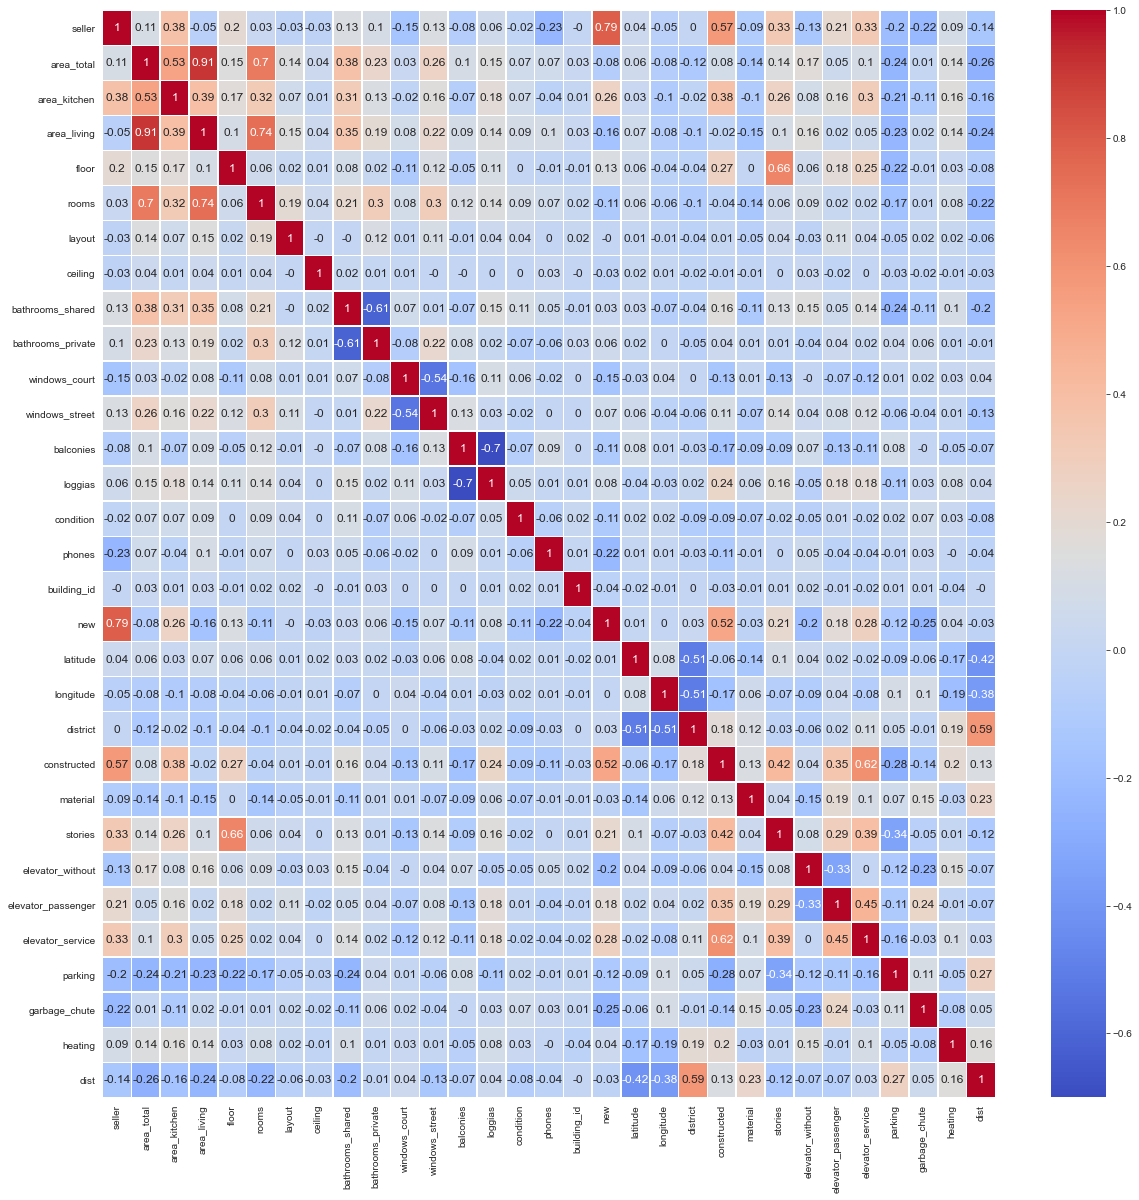

In [143]:
#heatmap
#data1=dataset[['ceiling','area_total', 'area_living','parking','bathrooms_tot']]

plt.figure(figsize = (20,20))
sns.heatmap(data=dataset.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

# Imputing NaN

In [147]:
model=XGBRegressor()
model2=lgb.LGBMRegressor()

In [148]:
data1=dataset[['district','latitude','longitude','dist']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['district','latitude','longitude','dist'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['district'] = data1['district']

In [146]:
data1=dataset2[['district','latitude','longitude','dist']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['district','latitude','longitude','dist'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['district'] = data1['district']

NameError: name 'model2' is not defined

In [ ]:
data1=dataset3[['district','latitude','longitude','dist']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['district','latitude','longitude','dist'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['district'] = data1['district']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['constructed','new','elevator_service','area_kitchen','floor','elevator_passenger','stories','parking','loggias']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['constructed','new','elevator_service','area_kitchen','floor','elevator_passenger','stories','parking','loggias'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['constructed'] = data1['constructed']

In [ ]:
data1=dataset2[['constructed','new','elevator_service','area_kitchen','floor','elevator_passenger','stories','parking','loggias']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['constructed','new','elevator_service','area_kitchen','floor','elevator_passenger','stories','parking','loggias'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['constructed'] = data1['constructed']

In [ ]:
data1=dataset3[['constructed','new','elevator_service','area_kitchen','floor','elevator_passenger','stories','parking','loggias']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['constructed','new','elevator_service','area_kitchen','floor','elevator_passenger','stories','parking','loggias'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['constructed'] = data1['constructed']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['area_kitchen','area_total','elevator_service','constructed','stories','bathrooms_shared','rooms','area_living','seller','new']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_kitchen','area_total','elevator_service','constructed','stories','bathrooms_shared','rooms','area_living','seller','new'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['area_kitchen'] = data1['area_kitchen']

In [ ]:
data1=dataset2[['area_kitchen','area_total','elevator_service','constructed','stories','bathrooms_shared','rooms','area_living','seller','new']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_kitchen','area_total','elevator_service','constructed','stories','bathrooms_shared','rooms','area_living','seller','new'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['area_kitchen'] = data1['area_kitchen']

In [ ]:
data1=dataset3[['area_kitchen','area_total','elevator_service','constructed','stories','bathrooms_shared','rooms','area_living','seller','new']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['area_kitchen','area_total','elevator_service','constructed','stories','bathrooms_shared','rooms','area_living','seller','new'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['area_kitchen'] = data1['area_kitchen']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['ceiling','building_id','area_total','rooms','area_living']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['ceiling','building_id','area_total','rooms','area_living'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['ceiling'] = data1['ceiling']

In [ ]:
data1=dataset2[['ceiling','building_id','area_total','rooms','area_living']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['ceiling','building_id','area_total','rooms','area_living'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['ceiling'] = data1['ceiling']

In [ ]:
data1=dataset3[['ceiling','building_id','area_total','rooms','area_living']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['ceiling','building_id','area_total','rooms','area_living'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['ceiling'] = data1['ceiling']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
#we decided to correct the wrong values we computed for the numeric variables using the median of them

In [ ]:
dataset.loc[(dataset['ceiling'] <= 0), 'ceiling'] = np.nan
dataset.loc[(dataset['area_living'] <= 0), 'area_living'] = np.nan
dataset.loc[(dataset['area_kitchen'] <= 0), 'area_kitchen'] = np.nan
dataset2.loc[(dataset2['ceiling'] <= 0), 'ceiling'] = np.nan
dataset2.loc[(dataset2['area_living'] <= 0), 'area_living'] = np.nan
dataset2.loc[(dataset2['area_kitchen'] <= 0), 'area_kitchen'] = np.nan
dataset3.loc[(dataset3['ceiling'] <= 0), 'ceiling'] = np.nan
dataset3.loc[(dataset3['area_living'] <= 0), 'area_living'] = np.nan
dataset3.loc[(dataset3['area_kitchen'] <= 0), 'area_kitchen'] = np.nan

dataset['ceiling'].fillna((dataset['ceiling'].median()), inplace=True)
dataset['area_living'].fillna((dataset['area_living'].median()), inplace=True)
dataset['area_kitchen'].fillna((dataset['area_kitchen'].median()), inplace=True)
dataset2['ceiling'].fillna((dataset2['ceiling'].median()), inplace=True)
dataset2['area_living'].fillna((dataset2['area_living'].median()), inplace=True)
dataset2['area_kitchen'].fillna((dataset2['area_kitchen'].median()), inplace=True)
dataset3['ceiling'].fillna((dataset3['ceiling'].median()), inplace=True)
dataset3['area_living'].fillna((dataset3['area_living'].median()), inplace=True)
dataset3['area_kitchen'].fillna((dataset3['area_kitchen'].median()), inplace=True)

In [ ]:
data1=dataset[['bathrooms_shared','area_kitchen','area_total','area_living','rooms','parking','dist','constructed','elevator_without']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['bathrooms_shared','area_kitchen','area_total','area_living','rooms','parking','dist','constructed','elevator_without'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['bathrooms_shared'] = data1['bathrooms_shared']

In [ ]:
data1=dataset2[['bathrooms_shared','area_kitchen','area_total','area_living','rooms','parking','dist','constructed','elevator_without']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['bathrooms_shared','area_kitchen','area_total','area_living','rooms','parking','dist','constructed','elevator_without'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['bathrooms_shared'] = data1['bathrooms_shared']

In [ ]:
data1=dataset3[['bathrooms_shared','area_kitchen','area_total','area_living','rooms','parking','dist','constructed','elevator_without']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['bathrooms_shared','area_kitchen','area_total','area_living','rooms','parking','dist','constructed','elevator_without'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['bathrooms_shared'] = data1['bathrooms_shared']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['bathrooms_private','bathrooms_shared','windows_street','area_living','area_total','rooms']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['bathrooms_private','bathrooms_shared','windows_street','area_living','area_total','rooms'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['bathrooms_private'] = data1['bathrooms_private']

In [ ]:
data1=dataset2[['bathrooms_private','bathrooms_shared','windows_street','area_living','area_total','rooms']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['bathrooms_private','bathrooms_shared','windows_street','area_living','area_total','rooms'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['bathrooms_private'] = data1['bathrooms_private']

In [ ]:
data1=dataset3[['bathrooms_private','bathrooms_shared','windows_street','area_living','area_total','rooms']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['bathrooms_private','bathrooms_shared','windows_street','area_living','area_total','rooms'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['bathrooms_private'] = data1['bathrooms_private']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['windows_street','area_total','area_living','rooms','bathrooms_private','stories','balconies','dist']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['windows_street','area_total','area_living','rooms','bathrooms_private','stories','balconies','dist'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['windows_street'] = data1['windows_street']

In [ ]:
data1=dataset2[['windows_street','area_total','area_living','rooms','bathrooms_private','stories','balconies','dist']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['windows_street','area_total','area_living','rooms','bathrooms_private','stories','balconies','dist'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['windows_street'] = data1['windows_street']

In [ ]:
data1=dataset3[['windows_street','area_total','area_living','rooms','bathrooms_private','stories','balconies','dist']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['windows_street','area_total','area_living','rooms','bathrooms_private','stories','balconies','dist'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['windows_street'] = data1['windows_street']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['windows_court','windows_street','seller','loggias','balconies','elevator_service','new','constructed','stories']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['windows_court','windows_street','seller','loggias','balconies','elevator_service','new','constructed','stories'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['windows_court'] = data1['windows_court']

In [ ]:
data1=dataset2[['windows_court','windows_street','seller','loggias','balconies','elevator_service','new','constructed','stories']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['windows_court','windows_street','seller','loggias','balconies','elevator_service','new','constructed','stories'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['windows_court'] = data1['windows_court']

In [ ]:
data1=dataset3[['windows_court','windows_street','seller','loggias','balconies','elevator_service','new','constructed','stories']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['windows_court','windows_street','seller','loggias','balconies','elevator_service','new','constructed','stories'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['windows_court'] = data1['windows_court']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['elevator_without','area_total','bathrooms_shared','garbage_chute','area_living','new','heating','material']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_without','area_total','bathrooms_shared','garbage_chute','area_living','new','heating','material'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['elevator_without'] = data1['elevator_without']

In [ ]:
data1=dataset2[['elevator_without','area_total','bathrooms_shared','garbage_chute','area_living','new','heating','material']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_without','area_total','bathrooms_shared','garbage_chute','area_living','new','heating','material'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['elevator_without'] = data1['elevator_without']

In [ ]:
data1=dataset3[['elevator_without','area_total','bathrooms_shared','garbage_chute','area_living','new','heating','material']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_without','area_total','bathrooms_shared','garbage_chute','area_living','new','heating','material'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['elevator_without'] = data1['elevator_without']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['parking','area_total','stories','floor','constructed','bathrooms_shared','dist','area_living','area_kitchen','seller']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['parking','area_total','stories','floor','constructed','bathrooms_shared','dist','area_living','area_kitchen','seller'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['parking'] = data1['parking']

In [ ]:
data1=dataset2[['parking','area_total','stories','floor','constructed','bathrooms_shared','dist','area_living','area_kitchen','seller']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['parking','area_total','stories','floor','constructed','bathrooms_shared','dist','area_living','area_kitchen','seller'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['parking'] = data1['parking']

In [ ]:
data1=dataset3[['parking','area_total','stories','floor','constructed','bathrooms_shared','dist','area_living','area_kitchen','seller']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['parking','area_total','stories','floor','constructed','bathrooms_shared','dist','area_living','area_kitchen','seller'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['parking'] = data1['parking']


In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['seller','area_kitchen','floor','new','constructed','stories','elevator_service','elevator_passenger','parking','garbage_chute','phones']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['seller','area_kitchen','floor','new','constructed','stories','elevator_service','elevator_passenger','parking','garbage_chute','phones'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['seller'] = data1['seller']

In [ ]:
data1=dataset2[['seller','area_kitchen','floor','new','constructed','stories','elevator_service','elevator_passenger','parking','garbage_chute','phones']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['seller','area_kitchen','floor','new','constructed','stories','elevator_service','elevator_passenger','parking','garbage_chute','phones'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['seller'] = data1['seller']

In [ ]:
data1=dataset3[['seller','area_kitchen','floor','new','constructed','stories','elevator_service','elevator_passenger','parking','garbage_chute','phones']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['seller','area_kitchen','floor','new','constructed','stories','elevator_service','elevator_passenger','parking','garbage_chute','phones'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['seller'] = data1['seller']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['balconies','rooms','windows_court','windows_street','constructed','new','area_total','elevator_service','elevator_passenger']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['balconies','rooms','windows_court','windows_street','constructed','new','area_total','elevator_service','elevator_passenger'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['balconies'] = data1['balconies']

In [ ]:
data1=dataset2[['balconies','rooms','windows_court','windows_street','constructed','new','area_total','elevator_service','elevator_passenger']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['balconies','rooms','windows_court','windows_street','constructed','new','area_total','elevator_service','elevator_passenger'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['balconies'] = data1['balconies']

In [ ]:
data1=dataset3[['balconies','rooms','windows_court','windows_street','constructed','new','area_total','elevator_service','elevator_passenger']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['balconies','rooms','windows_court','windows_street','constructed','new','area_total','elevator_service','elevator_passenger'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['balconies'] = data1['balconies']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['loggias','balconies','area_total','area_kitchen','area_living','rooms','floor','bathrooms_shared','constructed','stories','elevator_service','elevator_passenger']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['loggias','balconies','area_total','area_kitchen','area_living','rooms','floor','bathrooms_shared','constructed','stories','elevator_service','elevator_passenger'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['loggias'] = data1['loggias']

In [ ]:
data1=dataset2[['loggias','balconies','area_total','area_kitchen','area_living','rooms','floor','bathrooms_shared','constructed','stories','elevator_service','elevator_passenger']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['loggias','balconies','area_total','area_kitchen','area_living','rooms','floor','bathrooms_shared','constructed','stories','elevator_service','elevator_passenger'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['loggias'] = data1['loggias']

In [ ]:
data1=dataset3[['loggias','balconies','area_total','area_kitchen','area_living','rooms','floor','bathrooms_shared','constructed','stories','elevator_service','elevator_passenger']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['loggias','balconies','area_total','area_kitchen','area_living','rooms','floor','bathrooms_shared','constructed','stories','elevator_service','elevator_passenger'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['loggias'] = data1['loggias']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['condition','bathrooms_shared','new','district','constructed','rooms','area_living','material','dist']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['condition','bathrooms_shared','new','district','constructed','rooms','area_living','material','dist'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['condition'] = data1['condition']

In [ ]:
data1=dataset2[['condition','bathrooms_shared','new','district','constructed','rooms','area_living','material','dist']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['condition','bathrooms_shared','new','district','constructed','rooms','area_living','material','dist'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['condition'] = data1['condition']

In [ ]:
data1=dataset3[['condition','bathrooms_shared','new','district','constructed','rooms','area_living','material','dist']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['condition','bathrooms_shared','new','district','constructed','rooms','area_living','material','dist'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['condition'] = data1['condition']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['phones','seller','new','constructed','area_living','balconies','rooms']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['phones','seller','new','constructed','area_living','balconies','rooms'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['phones'] = data1['phones']

In [ ]:
data1=dataset2[['phones','seller','new','constructed','area_living','balconies','rooms']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['phones','seller','new','constructed','area_living','balconies','rooms'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['phones'] = data1['phones']

In [ ]:
data1=dataset3[['phones','seller','new','constructed','area_living','balconies','rooms']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['phones','seller','new','constructed','area_living','balconies','rooms'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['phones'] = data1['phones']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['material','dist','area_total','garbage_chute','area_living','rooms','district','constructed','latitude','elevator_without','elevator_passenger']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['material','dist','area_total','garbage_chute','area_living','rooms','district','constructed','latitude','elevator_without','elevator_passenger'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['material'] = data1['material']

In [ ]:
data1=dataset2[['material','dist','area_total','garbage_chute','area_living','rooms','district','constructed','latitude','elevator_without','elevator_passenger']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['material','dist','area_total','garbage_chute','area_living','rooms','district','constructed','latitude','elevator_without','elevator_passenger'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['material'] = data1['material']

In [ ]:
data1=dataset3[['material','dist','area_total','garbage_chute','area_living','rooms','district','constructed','latitude','elevator_without','elevator_passenger']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['material','dist','area_total','garbage_chute','area_living','rooms','district','constructed','latitude','elevator_without','elevator_passenger'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['material'] = data1['material']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['elevator_passenger','floor','area_kitchen','garbage_chute','rooms','new','loggias','material','constructed','stories','elevator_without','seller']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_passenger','floor','area_kitchen','garbage_chute','rooms','new','loggias','material','constructed','stories','elevator_without','seller'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['elevator_passenger'] = data1['elevator_passenger']

In [ ]:
data1=dataset2[['elevator_passenger','floor','area_kitchen','garbage_chute','rooms','new','loggias','material','constructed','stories','elevator_without','seller']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_passenger','floor','area_kitchen','garbage_chute','rooms','new','loggias','material','constructed','stories','elevator_without','seller'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['elevator_passenger'] = data1['elevator_passenger']

In [ ]:
data1=dataset3[['elevator_passenger','floor','area_kitchen','garbage_chute','rooms','new','loggias','material','constructed','stories','elevator_without','seller']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_passenger','floor','area_kitchen','garbage_chute','rooms','new','loggias','material','constructed','stories','elevator_without','seller'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['elevator_passenger'] = data1['elevator_passenger']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['elevator_service','elevator_passenger','stories','constructed','parking','bathrooms_shared','floor','area_kitchen','new','loggias','seller']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_service','elevator_passenger','stories','constructed','parking','bathrooms_shared','floor','area_kitchen','new','loggias','seller'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['elevator_service'] = data1['elevator_service']

In [ ]:
data1=dataset2[['elevator_service','elevator_passenger','stories','constructed','parking','bathrooms_shared','floor','area_kitchen','new','loggias','seller']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_service','elevator_passenger','stories','constructed','parking','bathrooms_shared','floor','area_kitchen','new','loggias','seller'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['elevator_service'] = data1['elevator_service']

In [ ]:
data1=dataset3[['elevator_service','elevator_passenger','stories','constructed','parking','bathrooms_shared','floor','area_kitchen','new','loggias','seller']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['elevator_service','elevator_passenger','stories','constructed','parking','bathrooms_shared','floor','area_kitchen','new','loggias','seller'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['elevator_service'] = data1['elevator_service']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['garbage_chute','constructed','parking','bathrooms_shared','material','new','seller','elevator_without','elevator_passenger','longitude']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['garbage_chute','constructed','parking','bathrooms_shared','material','new','seller','elevator_without','elevator_passenger','longitude'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['garbage_chute'] = data1['garbage_chute']

In [ ]:
data1=dataset2[['garbage_chute','constructed','parking','bathrooms_shared','material','new','seller','elevator_without','elevator_passenger','longitude']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['garbage_chute','constructed','parking','bathrooms_shared','material','new','seller','elevator_without','elevator_passenger','longitude'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['garbage_chute'] = data1['garbage_chute']

In [ ]:
data1=dataset3[['garbage_chute','constructed','parking','bathrooms_shared','material','new','seller','elevator_without','elevator_passenger','longitude']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['garbage_chute','constructed','parking','bathrooms_shared','material','new','seller','elevator_without','elevator_passenger','longitude'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['garbage_chute'] = data1['garbage_chute']

In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['heating','dist','area_kitchen','constructed','area_total','area_living','elevator_without','latitude','longitude','district']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['heating','dist','area_kitchen','constructed','area_total','area_living','elevator_without','latitude','longitude','district'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['heating'] = data1['heating']

In [ ]:
data1=dataset2[['heating','dist','area_kitchen','constructed','area_total','area_living','elevator_without','latitude','longitude','district']]

imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['heating','dist','area_kitchen','constructed','area_total','area_living','elevator_without','latitude','longitude','district'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['heating'] = data1['heating']

In [ ]:
data1=dataset3[['heating','dist','area_kitchen','constructed','area_total','area_living','elevator_without','latitude','longitude','district']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['heating','dist','area_kitchen','constructed','area_total','area_living','elevator_without','latitude','longitude','district'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['heating'] = data1['heating']


In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
data1=dataset[['layout','area_total','area_living','rooms','bathrooms_private','windows_street','elevator_passenger','area_kitchen']]


imp = Pipeline([("imputer",  IterativeImputer(estimator=model, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['layout','area_total','area_living','rooms','bathrooms_private','windows_street','elevator_passenger','area_kitchen'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset['layout'] = data1['layout']

In [ ]:
data1=dataset2[['layout','area_total','area_living','rooms','bathrooms_private','windows_street','elevator_passenger','area_kitchen']]


imp = Pipeline([("imputer",  IterativeImputer(estimator=model2, verbose=False, max_iter=20, tol=1e-5, imputation_order='roman')),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['layout','area_total','area_living','rooms','bathrooms_private','windows_street','elevator_passenger','area_kitchen'])))])

data1=imp.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset2['layout'] = data1['layout']

In [ ]:
data1=dataset3[['layout','area_total','area_living','rooms','bathrooms_private','windows_street','elevator_passenger','area_kitchen']]

imputer = Pipeline([("imputer", KNNImputer(n_neighbors=11)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['layout','area_total','area_living','rooms','bathrooms_private','windows_street','elevator_passenger','area_kitchen'])))])


data1=imputer.fit_transform(data1)
data1 = data1.reset_index(drop=True)

dataset3['layout'] = data1['layout']


In [ ]:
dataset = dataset.reset_index(drop=True)
dataset2 = dataset2.reset_index(drop=True)
dataset3 = dataset3.reset_index(drop=True)

In [ ]:
dataset.isnull().sum()

In [ ]:
dataset2.isnull().sum()

In [ ]:
dataset3.isnull().sum()

.

the only NaN present are in the feature 'new': this because we decided to compute all the values of this features based just on the feature 'constructed'. In particular, if an apartment was constructed before 2013, it's not new (0), otherwise it is new (1). We are doing it after the weighted average, we we will create the new features.

In [ ]:
dataset3.shape

In [ ]:
data.shape

we create a new dataset for the train e test of all the three different datasets (it was necessary to check the size of the data becuase if we remove outliers we have to change the index in order to select the right data train and test)

In [ ]:
prova=dataset.iloc[:23285,:]
prova_test=dataset.iloc[23285:,:]

prova2=dataset2.iloc[:23285,:]
prova_test2=dataset2.iloc[23285:,:]

prova3=dataset3.iloc[:23285,:]
prova_test3=dataset3.iloc[23285:,:]

In [ ]:
prova = prova.reset_index(drop=True)
prova_test = prova_test.reset_index(drop=True)
prova2 = prova2.reset_index(drop=True)
prova_test2 = prova_test2.reset_index(drop=True)
prova3 = prova3.reset_index(drop=True)
prova_test3 = prova_test3.reset_index(drop=True)

In [168]:
#here wew do the weighted average between the three imputer
data["seller"] = 0.45*prova["seller"] + 0.35*prova2["seller"] + 0.20*prova3["seller"]
data["area_kitchen"] = 0.45*prova["area_kitchen"] + 0.35*prova2["area_kitchen"] + 0.20*prova3["area_kitchen"]
data["area_living"] = 0.45*prova["area_living"] + 0.35*prova2["area_living"] + 0.20*prova3["area_living"]
data["floor"] = 0.45*prova["floor"] + 0.35*prova2["floor"] + 0.20*prova3["floor"]
data["rooms"] = 0.45*prova["rooms"] + 0.35*prova2["rooms"] + 0.20*prova3["rooms"]
data["layout"] = 0.45*prova["layout"] + 0.35*prova2["layout"] + 0.20*prova3["layout"]
data["ceiling"] = 0.45*prova["ceiling"] + 0.35*prova2["ceiling"] + 0.20*prova3["ceiling"]
data["bathrooms_shared"] = 0.45*prova["bathrooms_shared"] + 0.35*prova2["bathrooms_shared"] + 0.20*prova3["bathrooms_shared"]
data["bathrooms_private"] = 0.45*prova["bathrooms_private"] + 0.35*prova2["bathrooms_private"] + 0.20*prova3["bathrooms_private"]
data["windows_court"] = 0.45*prova["windows_court"] + 0.35*prova2["windows_court"] + 0.20*prova3["windows_court"]
data["windows_street"] = 0.45*prova["windows_street"] + 0.35*prova2["windows_street"] + 0.20*prova3["windows_street"]
data["balconies"] = 0.45*prova["balconies"] + 0.35*prova2["balconies"] + 0.20*prova3["balconies"]
data["loggias"] = 0.45*prova["loggias"] + 0.35*prova2["loggias"] + 0.20*prova3["loggias"]
data["condition"] = 0.45*prova["condition"] + 0.35*prova2["condition"] + 0.20*prova3["condition"]
data["phones"] = 0.45*prova["phones"] + 0.35*prova2["phones"] + 0.20*prova3["phones"]
data["new"] = 0.45*prova["new"] + 0.35*prova2["new"] + 0.20*prova3["new"]
data["district"] = 0.45*prova["district"] + 0.35*prova2["district"] + 0.20*prova3["district"]
data["constructed"] = 0.45*prova["constructed"] + 0.35*prova2["constructed"] + 0.20*prova3["constructed"]
data["material"] = 0.45*prova["material"] + 0.35*prova2["material"] + 0.20*prova3["material"]
data["stories"] = 0.45*prova["stories"] + 0.35*prova2["stories"] + 0.20*prova3["stories"]
data["elevator_without"] = 0.45*prova["elevator_without"] + 0.35*prova2["elevator_without"] + 0.20*prova3["elevator_without"]
data["elevator_passenger"] = 0.45*prova["elevator_passenger"] + 0.35*prova2["elevator_passenger"] + 0.20*prova3["elevator_passenger"]
data["elevator_service"] = 0.45*prova["elevator_service"] + 0.35*prova2["elevator_service"] + 0.20*prova3["elevator_service"]
data["parking"] = 0.45*prova["parking"] + 0.35*prova2["parking"] + 0.20*prova3["parking"]
data["garbage_chute"] = 0.45*prova["garbage_chute"] + 0.35*prova2["garbage_chute"] + 0.20*prova3["garbage_chute"]
data["heating"] = 0.45*prova["heating"] + 0.35*prova2["heating"] + 0.20*prova3["heating"]

data_test["seller"] = 0.45*prova_test["seller"] + 0.35*prova_test2["seller"] + 0.20*prova_test3["seller"]
data_test["area_kitchen"] = 0.45*prova_test["area_kitchen"] + 0.35*prova_test2["area_kitchen"] + 0.20*prova_test3["area_kitchen"]
data_test["area_living"] = 0.45*prova_test["area_living"] + 0.35*prova_test2["area_living"] + 0.20*prova_test3["area_living"]
data_test["floor"] = 0.45*prova_test["floor"] + 0.35*prova_test2["floor"] + 0.20*prova_test3["floor"]
data_test["rooms"] = 0.45*prova_test["rooms"] + 0.35*prova_test2["rooms"] + 0.20*prova_test3["rooms"]
data_test["layout"] = 0.45*prova_test["layout"] + 0.35*prova_test2["layout"] + 0.20*prova_test3["layout"]
data_test["ceiling"] = 0.45*prova_test["ceiling"] + 0.35*prova_test2["ceiling"] + 0.20*prova_test3["ceiling"]
data_test["bathrooms_shared"] = 0.45*prova_test["bathrooms_shared"] + 0.35*prova_test2["bathrooms_shared"] + 0.20*prova_test3["bathrooms_shared"]
data_test["bathrooms_private"] = 0.45*prova_test["bathrooms_private"] + 0.35*prova_test2["bathrooms_private"] + 0.20*prova_test3["bathrooms_private"]
data_test["windows_court"] = 0.45*prova_test["windows_court"] + 0.35*prova_test2["windows_court"] + 0.20*prova_test3["windows_court"]
data_test["windows_street"] = 0.45*prova_test["windows_street"] + 0.35*prova_test2["windows_street"] + 0.20*prova_test3["windows_street"]
data_test["balconies"] = 0.45*prova_test["balconies"] + 0.35*prova_test2["balconies"] + 0.20*prova_test3["balconies"]
data_test["loggias"] = 0.45*prova_test["loggias"] + 0.35*prova_test2["loggias"] + 0.20*prova_test3["loggias"]
data_test["condition"] = 0.45*prova_test["condition"] + 0.35*prova_test2["condition"] + 0.20*prova_test3["condition"]
data_test["phones"] = 0.45*prova_test["phones"] + 0.35*prova_test2["phones"] + 0.20*prova_test3["phones"]
data_test["new"] = 0.45*prova_test["new"] + 0.35*prova_test2["new"] + 0.20*prova_test3["new"]
data_test["district"] = 0.45*prova_test["district"] + 0.35*prova_test2["district"] + 0.20*prova_test3["district"]
data_test["constructed"] = 0.45*prova_test["constructed"] + 0.35*prova_test2["constructed"] + 0.20*prova_test3["constructed"]
data_test["material"] = 0.45*prova_test["material"] + 0.35*prova_test2["material"] + 0.20*prova_test3["material"]
data_test["stories"] = 0.45*prova_test["stories"] + 0.35*prova_test2["stories"] + 0.20*prova_test3["stories"]
data_test["elevator_without"] = 0.45*prova_test["elevator_without"] + 0.35*prova_test2["elevator_without"] + 0.20*prova_test3["elevator_without"]
data_test["elevator_passenger"] = 0.45*prova_test["elevator_passenger"] + 0.35*prova_test2["elevator_passenger"] + 0.20*prova_test3["elevator_passenger"]
data_test["elevator_service"] = 0.45*prova_test["elevator_service"] + 0.35*prova_test2["elevator_service"] + 0.20*prova_test3["elevator_service"]
data_test["parking"] = 0.45*prova_test["parking"] + 0.35*prova_test2["parking"] + 0.20*prova_test3["parking"]
data_test["garbage_chute"] = 0.45*prova_test["garbage_chute"] + 0.35*prova_test2["garbage_chute"] + 0.20*prova_test3["garbage_chute"]
data_test["heating"] = 0.45*prova_test["heating"] + 0.35*prova_test2["heating"] + 0.20*prova_test3["heating"]

In [169]:
#we convert the values in order to not have decimals

data["condition"] = data["condition"].round(0)
data["phones"] = data["phones"].round(0)
data["district"] = data["district"].round(0)
data["material"] = data["material"].round(0)
data["elevator_without"] = data["elevator_without"].round(0)
data["elevator_passenger"] = data["elevator_passenger"].round(0)
data["elevator_service"] = data["elevator_service"].round(0)
data["garbage_chute"] = data["garbage_chute"].round(0)
data["heating"] = data["heating"].round(0)
data["seller"] = data["seller"].round(0)
data["layout"] = data["layout"].round(0)
data["parking"] = data["parking"].round(0)
data["loggias"] = data["loggias"].round(0)
data["balconies"] = data["balconies"].round(0)
data["windows_street"] = data["windows_street"].round(0)
data["windows_court"] = data["windows_court"].round(0)
data["bathrooms_private"] = data["bathrooms_private"].round(0)
data["bathrooms_shared"] = data["bathrooms_shared"].round(0)
data["rooms"] = data["rooms"].round(0)
data["building_id"] = data["building_id"].round(0)
data["constructed"] = data["constructed"].round(0)
data["stories"] = data["stories"].round(0)
data["floor"] = data["floor"].round(0)
data['area_total']=data['area_total'].round(2)
data['area_living']=data['area_living'].round(2)
data['area_kitchen']=data['area_kitchen'].round(1)
data['ceiling']=data['ceiling'].round(2)


data_test["condition"] = data_test["condition"].round(0)
data_test["phones"] = data_test["phones"].round(0)
data_test["district"] = data_test["district"].round(0)
data_test["material"] = data_test["material"].round(0)
data_test["elevator_without"] = data_test["elevator_without"].round(0)
data_test["elevator_passenger"] = data_test["elevator_passenger"].round(0)
data_test["elevator_service"] = data_test["elevator_service"].round(0)
data_test["garbage_chute"] = data_test["garbage_chute"].round(0)
data_test["heating"] = data_test["heating"].round(0)
data_test["seller"] = data_test["seller"].round(0)
data_test["layout"] = data_test["layout"].round(0)
data_test["parking"] = data_test["parking"].round(0)
data_test["loggias"] = data_test["loggias"].round(0)
data_test["balconies"] = data_test["balconies"].round(0)
data_test["windows_street"] = data_test["windows_street"].round(0)
data_test["windows_court"] = data_test["windows_court"].round(0)
data_test["bathrooms_private"] = data_test["bathrooms_private"].round(0)
data_test["bathrooms_shared"] = data_test["bathrooms_shared"].round(0)
data_test["rooms"] = data_test["rooms"].round(0)
data_test["building_id"] = data_test["building_id"].round(0)
data_test["constructed"] = data_test["constructed"].round(0)
data_test["stories"] = data_test["stories"].round(0)
data_test["floor"] = data_test["floor"].round(0)
data_test['area_total']=data_test['area_total'].round(2)
data_test['area_living']=data_test['area_living'].round(2)
data_test['area_kitchen']=data_test['area_kitchen'].round(1)
data_test['ceiling']=data_test['ceiling'].round(2)

In [170]:
#we obtained some values out of the range, so we corrected them

data.loc[(data['bathrooms_shared'] >= 4), 'bathrooms_shared'] = 4
data.loc[(data['condition'] <=0), 'bathrooms_shared'] = 0
data.loc[(data['material'] <=0), 'material'] = 0
data_test.loc[(data_test['heating'] >= 3), 'heating'] = 3

# feature engineering

we decided to create some new useful variables to increase the accuracy of the prediction. Moreover we corrected the values of the variable 'new', based them on the year of construction

In [171]:
data['bathrooms_tot']=data["bathrooms_private"]+data["bathrooms_shared"]
data['windows_tot']=data["windows_court"]+data["windows_street"]
data['interior']=data["balconies"]+data["loggias"]
data['rel_floor'] = data['floor'] / data['stories'].astype(float)
data['rel_kitch_sq'] = data['area_kitchen'] / data['area_total'].astype(float)
data['area_per_room'] = data['area_living'] / data['rooms'].astype(float)
data['livArea_ratio'] = data['area_living'] / data['area_total'].astype(float)
data['yrs_old'] = 2025 - data['constructed'].astype(float)
data['avgfloor_sq'] = data['area_living']/data['stories'].astype(float) #living area per floor

data.loc[(data['constructed'] <= 2013), 'new'] = 0
data.loc[(data['constructed'] > 2013), 'new'] = 1
data['new'] = data['new'].round(0)


data_test['bathrooms_tot']=data_test["bathrooms_private"]+data_test["bathrooms_shared"]
data_test['windows_tot']=data_test["windows_court"]+data_test["windows_street"]
data_test['interior']=data_test["balconies"]+data_test["loggias"]
data_test['rel_floor'] = data_test['floor'] / data_test['stories'].astype(float)
data_test['rel_kitch_sq'] = data_test['area_kitchen'] / data_test['area_total'].astype(float)
data_test['area_per_room'] = data_test['area_living'] / data_test['rooms'].astype(float)
data_test['livArea_ratio'] = data_test['area_living'] / data_test['area_total'].astype(float)
data_test['yrs_old'] = 2025 - data_test['constructed'].astype(float)
data_test['avgfloor_sq'] = data_test['area_living']/data_test['stories'].astype(float) #living area per floor

data_test.loc[(data_test['constructed'] <= 2013), 'new'] = 0
data_test.loc[(data_test['constructed'] > 2013), 'new'] = 1
data_test['new'] = data_test['new'].round(0)

In [172]:
data["windows_tot"] = data["windows_tot"].round(0)
data["bathrooms_tot"] = data["bathrooms_tot"].round(0)
data["interior"] = data["interior"].round(0)

data_test["windows_tot"] = data_test["windows_tot"].round(0)
data_test["bathrooms_tot"] = data_test["bathrooms_tot"].round(0)
data_test["interior"] = data_test["interior"].round(0)

In [173]:
data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [174]:
pd.options.display.max_rows = 4000
data.describe()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,dist,bathrooms_tot,windows_tot,interior,rel_floor,rel_kitch_sq,area_per_room,livArea_ratio,yrs_old,avgfloor_sq
count,23285.000000,23285.000000,2.328500e+04,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,...,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000
mean,11642.000000,1.671205,2.355617e+07,74.450999,12.947086,42.154413,8.969594,2.189349,1.165686,2.914392,...,12.789443,1.164612,1.298003,1.125016,0.527765,0.200373,18.991591,0.556786,22.478205,3.453009
std,6721.944845,0.988960,5.264393e+07,58.671373,6.520121,34.904040,8.322039,1.076130,0.411503,0.525094,...,8.041171,0.670956,0.463083,0.459448,0.313935,0.086692,11.661579,0.167123,22.867103,4.898071
min,0.000000,0.000000,9.000000e+05,9.300000,1.000000,1.000000,1.000000,1.000000,0.000000,0.030000,...,0.410000,0.000000,0.000000,0.000000,0.027778,0.012496,0.700000,0.021978,2.000000,0.100000
25%,5821.000000,1.000000,7.490000e+06,42.000000,8.500000,20.300000,3.000000,1.000000,1.000000,2.670000,...,6.990000,1.000000,1.000000,1.000000,0.250000,0.137615,14.500000,0.484487,6.000000,1.303333
50%,11642.000000,1.000000,1.064500e+07,59.800000,11.300000,32.000000,7.000000,2.000000,1.000000,2.840000,...,11.690000,1.000000,1.000000,1.000000,0.500000,0.182519,16.750000,0.558345,12.000000,2.111111
75%,17463.000000,3.000000,2.050000e+07,84.800000,16.200000,48.400000,12.000000,3.000000,1.000000,3.060000,...,16.390000,1.000000,2.000000,1.000000,0.777778,0.242308,20.000000,0.624538,36.000000,3.600000
max,23284.000000,3.000000,2.600000e+09,2181.000000,100.000000,690.000000,95.000000,6.000000,2.000000,31.000000,...,69.280000,8.000000,2.000000,7.000000,6.400000,1.505376,456.800000,9.982143,170.000000,125.000000


In [175]:
data.isnull().sum()

id                    0
seller                0
price                 0
area_total            0
area_kitchen          0
area_living           0
floor                 0
rooms                 0
layout                0
ceiling               0
bathrooms_shared      0
bathrooms_private     0
windows_court         0
windows_street        0
balconies             0
loggias               0
condition             0
phones                0
building_id           0
new                   0
latitude              0
longitude             0
district              0
street                0
address               0
constructed           0
material              0
stories               0
elevator_without      0
elevator_passenger    0
elevator_service      0
parking               0
garbage_chute         0
heating               0
dist                  0
bathrooms_tot         0
windows_tot           0
interior              0
rel_floor             0
rel_kitch_sq          0
area_per_room         0
livArea_ratio   

we converted the ordinal variables in categorical to apply the dummies method.

In [193]:
data["condition"] = data["condition"].astype(object)
data["phones"] = data["phones"].astype(object)
data["new"] = data["new"].astype(object)
data["district"] = data["district"].astype(object)
data["material"] = data["material"].astype(object)
data["elevator_without"] = data["elevator_without"].astype(object)
data["elevator_passenger"] = data["elevator_passenger"].astype(object)
data["elevator_service"] = data["elevator_service"].astype(object)
data["garbage_chute"] = data["garbage_chute"].astype(object)
data["heating"] = data["heating"].astype(object)
data["windows_tot"] = data["windows_tot"].astype(object)
data["bathrooms_tot"] = data["bathrooms_tot"].astype(object)
data["interior"] = data["interior"].astype(object)
data["seller"] = data["seller"].astype(object)
data["layout"] = data["layout"].astype(object)
data["parking"] = data["parking"].astype(object)
data["loggias"] = data["loggias"].astype(object)
data["balconies"] = data["balconies"].astype(object)
data["windows_street"] = data["windows_street"].astype(object)
data["windows_court"] = data["windows_court"].astype(object)
data["bathrooms_private"] = data["bathrooms_private"].astype(object)
data["bathrooms_shared"] = data["bathrooms_shared"].astype(object)
data["rooms"] = data["rooms"].astype(object)

data_test["condition"] = data_test["condition"].astype(object)
data_test["phones"] = data_test["phones"].astype(object)
data_test["new"] = data_test["new"].astype(object)
data_test["district"] = data_test["district"].astype(object)
data_test["material"] = data_test["material"].astype(object)
data_test["elevator_without"] = data_test["elevator_without"].astype(object)
data_test["elevator_passenger"] = data_test["elevator_passenger"].astype(object)
data_test["elevator_service"] = data_test["elevator_service"].astype(object)
data_test["garbage_chute"] = data_test["garbage_chute"].astype(object)
data_test["heating"] = data_test["heating"].astype(object)
data_test["windows_tot"] = data_test["windows_tot"].astype(object)
data_test["bathrooms_tot"] = data_test["bathrooms_tot"].astype(object)
data_test["interior"] = data_test["interior"].astype(object)
data_test["seller"] = data_test["seller"].astype(object)
data_test["layout"] = data_test["layout"].astype(object)
data_test["parking"] = data_test["parking"].astype(object)
data_test["loggias"] = data_test["loggias"].astype(object)
data_test["balconies"] = data_test["balconies"].astype(object)
data_test["windows_street"] = data_test["windows_street"].astype(object)
data_test["windows_court"] = data_test["windows_court"].astype(object)
data_test["bathrooms_private"] = data_test["bathrooms_private"].astype(object)
data_test["bathrooms_shared"] = data_test["bathrooms_shared"].astype(object)
data_test["rooms"] = data_test["rooms"].astype(object)

In [177]:
data['yrs_old'] = pd.qcut(data['yrs_old'], 10, duplicates='drop')
data_test['yrs_old'] = pd.qcut(data_test['yrs_old'], 10, duplicates='drop')

In [178]:
from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 42

data['yrs_old'] = preprocessing.LabelEncoder().fit_transform(data['yrs_old'].values)
data_test['yrs_old'] = preprocessing.LabelEncoder().fit_transform(data_test['yrs_old'].values)

In [179]:
#we merged the data train and test to to speed up the process of normalization and creation of dummies

In [180]:
df_all=pd.concat([data, data_test], ignore_index=True)

In [181]:
# List of categorical features
cate_features = list(df_all.select_dtypes(include=['object', 'category']).columns)

# List of numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(df_all.select_dtypes(include=numeric_dtypes).columns)

# Normalization

In [182]:
#first we deleted the variable 'yrs_old' becuase we wanted to mantain their values without normalize them

data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

old=data['yrs_old']
old_test=data_test['yrs_old']


del data['yrs_old']
del data_test['yrs_old']

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'area_total'}>,
        <AxesSubplot:title={'center':'area_kitchen'}>,
        <AxesSubplot:title={'center':'area_living'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling'}>,
        <AxesSubplot:title={'center':'stories'}>],
       [<AxesSubplot:title={'center':'dist'}>,
        <AxesSubplot:title={'center':'rel_floor'}>,
        <AxesSubplot:title={'center':'rel_kitch_sq'}>,
        <AxesSubplot:title={'center':'area_per_room'}>],
       [<AxesSubplot:title={'center':'livArea_ratio'}>,
        <AxesSubplot:title={'center':'yrs_old'}>,
        <AxesSubplot:title={'center':'avgfloor_sq'}>, <AxesSubplot:>]],
      dtype=object)

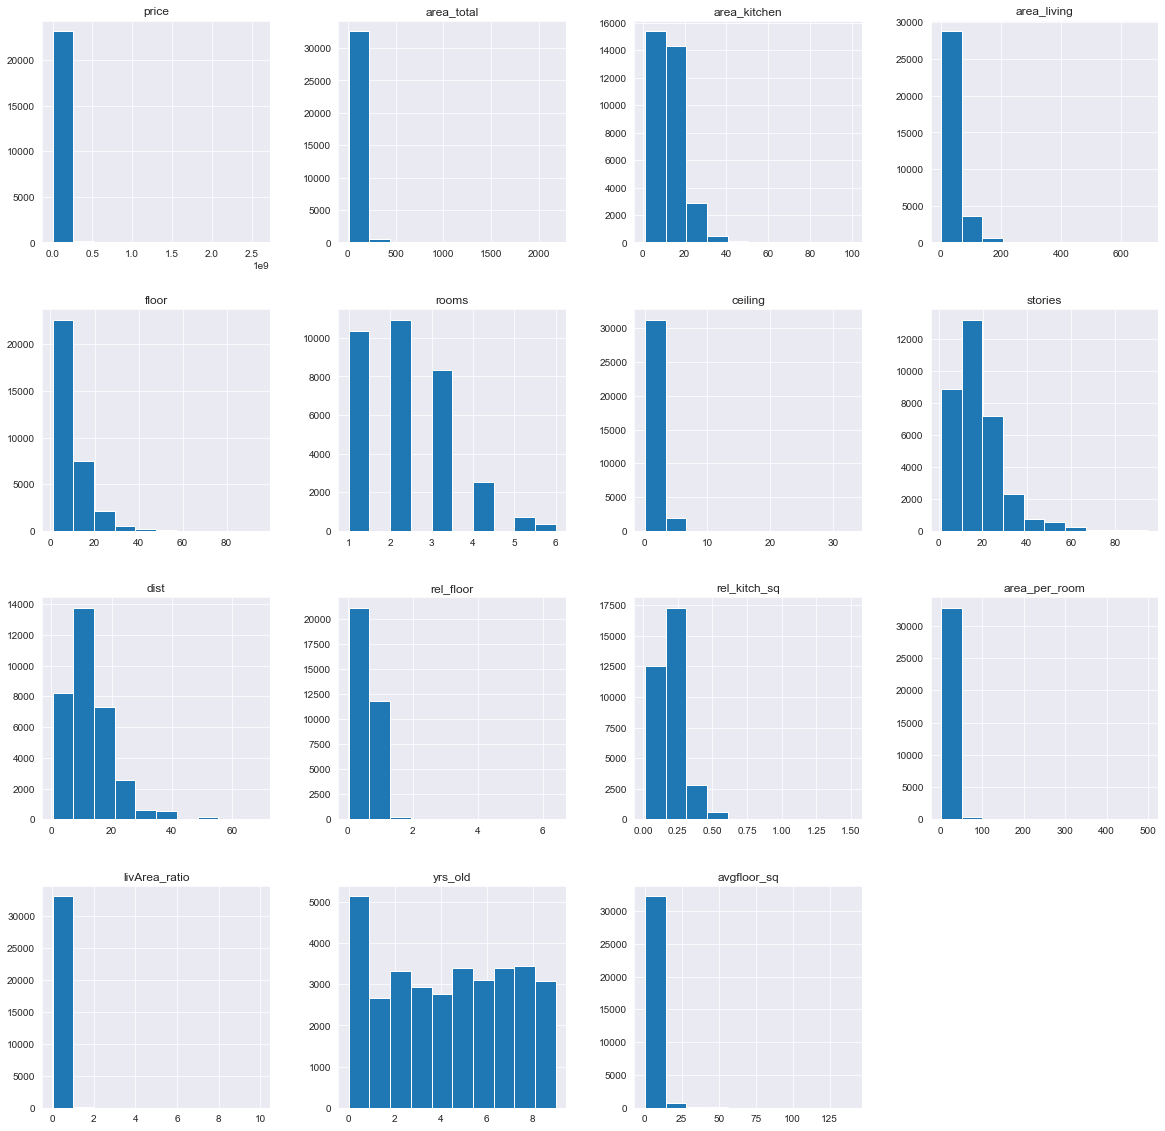

In [183]:
#visualization of the numerical features 

data_num = df_all[['price','area_total','area_kitchen','area_living','floor','rooms','ceiling','bathrooms_shared','bathrooms_private','district','stories','dist','bathrooms_tot','rel_floor','rel_kitch_sq','area_per_room','livArea_ratio','yrs_old','avgfloor_sq']]
data_num.hist(figsize=(20,20))

In [184]:
# Normalize skewness feature using Log function
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.40]
print(skew_features)           

ceiling          30.960937
area_per_room    13.066331
livArea_ratio    12.957083
avgfloor_sq       7.606942
area_total        7.504211
area_living       4.051967
floor             2.488207
stories           2.067154
dist              1.817895
area_kitchen      1.797849
rel_kitch_sq      1.314671
rooms             0.830064
rel_floor         0.749138
latitude         -0.470964
constructed      -1.484832
dtype: float64


In [185]:
# Apply Box cox for skewness > 0.40
for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

In [186]:
data.shape

(23285, 43)

In [187]:
data=df_all.iloc[:23285,:]
data_test=df_all.iloc[23285:,:]

In [188]:
data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [189]:
data['yrs_old']=old
data_test['yrs_old']=old_test

# DUMMIES

In [190]:
data["rooms"] = data["rooms"].astype(float)
data_test["rooms"] = data_test["rooms"].astype(float)

In [191]:
cate_features

['seller',
 'layout',
 'bathrooms_shared',
 'bathrooms_private',
 'windows_court',
 'windows_street',
 'balconies',
 'loggias',
 'condition',
 'phones',
 'new',
 'district',
 'street',
 'address',
 'material',
 'elevator_without',
 'elevator_passenger',
 'elevator_service',
 'parking',
 'garbage_chute',
 'heating',
 'bathrooms_tot',
 'windows_tot',
 'interior']

In [194]:
#convert categorical variable into dummy variables:
df_cat=data.select_dtypes(include=['object'])
dummies = pd.get_dummies(df_cat[['seller',
 'rooms',
 'layout',
 'bathrooms_shared',
 'bathrooms_private',
 'windows_court',
 'windows_street',
 'balconies',
 'loggias',
 'condition',
 'phones',
 'new',
 'district',
 'material',
 'elevator_without',
 'elevator_passenger',
 'elevator_service',
 'parking',
 'garbage_chute',
 'heating',
 'bathrooms_tot',
 'windows_tot',
 'interior']],drop_first=True) 

df_cat2=data_test.select_dtypes(include=['object'])
dummies2 = pd.get_dummies(df_cat2[['seller',
 'rooms',
 'layout',
 'bathrooms_shared',
 'bathrooms_private',
 'windows_court',
 'windows_street',
 'balconies',
 'loggias',
 'condition',
 'phones',
 'new',
 'district',
 'material',
 'elevator_without',
 'elevator_passenger',
 'elevator_service',
 'parking',
 'garbage_chute',
 'heating',
 'bathrooms_tot',
 'windows_tot',
 'interior']],drop_first=True) 

dummies.head()

#the new dataset with only the categorical attributes has 198 columns due to the conversation of these attributes into dummies.

,seller_1.0,seller_2.0,seller_3.0,rooms_1.0986122886681098,rooms_1.3862943611198906,rooms_1.6094379124341003,rooms_1.791759469228055,rooms_1.9459101490553132,layout_1.0,layout_2.0,...,bathrooms_tot_8.0,windows_tot_1.0,windows_tot_2.0,interior_1.0,interior_2.0,interior_3.0,interior_4.0,interior_5.0,interior_6.0,interior_7.0
0,0,0,1,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0


In [195]:
df_num=data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
df_num2=data_test.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

In [196]:
data=pd.concat([dummies,df_num], axis = 1)
data_test=pd.concat([dummies2,df_num2], axis = 1)

In [197]:
data.shape

(23285, 96)

In [198]:
data_test.shape

(9937, 96)

In [199]:
data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [200]:
#check if all the values have sense or if there are some infinite or NaN values

pd.set_option("display.max_columns", None)
# display the dataframe head
data.head()

,seller_1.0,seller_2.0,seller_3.0,rooms_1.0986122886681098,rooms_1.3862943611198906,rooms_1.6094379124341003,rooms_1.791759469228055,rooms_1.9459101490553132,layout_1.0,layout_2.0,bathrooms_shared_1.0,bathrooms_shared_2.0,bathrooms_shared_3.0,bathrooms_shared_4.0,bathrooms_private_1.0,bathrooms_private_2.0,bathrooms_private_3.0,bathrooms_private_4.0,windows_court_1.0,windows_street_1.0,balconies_1.0,balconies_2.0,balconies_3.0,balconies_4.0,loggias_1.0,loggias_2.0,loggias_3.0,loggias_4.0,condition_1.0,condition_2.0,condition_3.0,phones_1.0,phones_2.0,new_1.0,district_1.0,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,elevator_without_1.0,elevator_passenger_1.0,elevator_service_1.0,parking_1.0,parking_2.0,garbage_chute_1.0,heating_1.0,heating_2.0,heating_3.0,bathrooms_tot_1.0,bathrooms_tot_2.0,bathrooms_tot_3.0,bathrooms_tot_4.0,bathrooms_tot_5.0,bathrooms_tot_6.0,bathrooms_tot_7.0,bathrooms_tot_8.0,windows_tot_1.0,windows_tot_2.0,interior_1.0,interior_2.0,interior_3.0,interior_4.0,interior_5.0,interior_6.0,interior_7.0,id,price,area_total,area_kitchen,area_living,floor,ceiling,building_id,latitude,longitude,constructed,stories,dist,rel_floor,rel_kitch_sq,area_per_room,livArea_ratio,yrs_old,avgfloor_sq
0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,7139520.0,4.097672,2.602690,3.465736,1.098612,1.294727,4076,4.035020,37.478055,7.611842,2.302585,3.248046,0.200671,0.191569,2.803360,0.421108,0,1.491655
1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,10500000.0,4.488636,2.721295,3.891820,2.944439,1.311032,1893,4.040615,37.666647,7.606387,3.258097,2.604170,0.542324,0.149595,2.833213,0.435318,5,1.071584
2,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2,9019650.0,4.375757,3.157000,3.732896,2.564949,1.294727,5176,4.037127,37.515335,7.611842,2.772589,2.547099,0.587787,0.252022,2.681022,0.418543,0,1.313724
3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3,10500000.0,4.488636,2.708050,3.891820,2.944439,1.308333,1893,4.040615,37.666647,7.606387,3.258097,2.604170,0.542324,0.147636,2.833213,0.435318,5,1.071584
4,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4,13900000.0,4.369448,2.890372,3.583519,2.079442,1.360977,6604,4.035846,37.451438,7.609862,2.772589,3.079614,0.382992,0.197168,2.917771,0.370679,3,1.203973


In [201]:
data_test.head()

,seller_1.0,seller_2.0,seller_3.0,rooms_1.0986122886681098,rooms_1.3862943611198906,rooms_1.6094379124341003,rooms_1.791759469228055,rooms_1.9459101490553132,layout_1.0,layout_2.0,bathrooms_shared_1.0,bathrooms_shared_2.0,bathrooms_shared_3.0,bathrooms_shared_4.0,bathrooms_private_1.0,bathrooms_private_2.0,bathrooms_private_3.0,bathrooms_private_4.0,windows_court_1.0,windows_street_1.0,balconies_1.0,balconies_2.0,balconies_3.0,balconies_4.0,loggias_1.0,loggias_2.0,loggias_3.0,loggias_4.0,condition_0.0,condition_1.0,condition_2.0,condition_3.0,phones_1.0,phones_2.0,new_1.0,district_1.0,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,elevator_without_1.0,elevator_passenger_1.0,elevator_service_1.0,parking_1.0,parking_2.0,garbage_chute_1.0,heating_1.0,heating_2.0,heating_3.0,bathrooms_tot_1.0,bathrooms_tot_2.0,bathrooms_tot_3.0,bathrooms_tot_4.0,bathrooms_tot_5.0,bathrooms_tot_6.0,bathrooms_tot_7.0,bathrooms_tot_8.0,windows_tot_1.0,windows_tot_2.0,interior_1.0,interior_2.0,interior_3.0,interior_4.0,interior_6.0,interior_8.0,id,price,area_total,area_kitchen,area_living,floor,ceiling,building_id,latitude,longitude,constructed,stories,dist,rel_floor,rel_kitch_sq,area_per_room,livArea_ratio,yrs_old,avgfloor_sq
0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,23285,NaN,4.282206,2.639057,3.673004,1.098612,1.408545,5148,4.038871,37.549040,7.609862,3.044522,1.693779,0.095310,0.167270,3.673004,0.430089,3,1.071070
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,23286,NaN,4.007333,1.609438,3.931826,1.609438,1.386294,1290,4.035858,37.452651,7.609862,2.772589,3.074543,0.236389,0.071459,3.931826,0.655407,3,1.466337
2,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,23287,NaN,3.698830,3.025291,2.501436,2.397895,1.294727,681,4.036310,37.413718,7.611842,2.302585,3.031582,0.747214,0.403772,2.501436,0.250186,0,0.808458
3,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,23288,NaN,4.125520,2.653242,3.553346,1.791759,1.406097,4261,4.035462,37.479510,7.608374,2.890372,3.140698,0.257829,0.196182,2.888425,0.442853,4,1.097239
4,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,23289,NaN,3.555348,2.302585,2.890372,2.708050,1.321756,7530,4.034560,37.343829,7.609367,2.890372,3.471656,0.600774,0.234840,2.890372,0.405465,4,0.693147


In [202]:
#we have to have the same columns between the data train and test. So we checked if there are some discrepancies between them 
#and we deleted the features (created with the dummies) which don't appear also in the other dataframe

In [203]:
k=data_test.columns.difference(data.columns)
k

Index(['condition_0.0', 'interior_8.0'], dtype='object')

In [204]:
k=data.columns.difference(data_test.columns)
k

Index(['interior_5.0', 'interior_7.0'], dtype='object')

In [205]:
#depending of the pre-processing, we can have different discrepancies
del data['interior_5.0']
del data['interior_7.0']

del data_test['interior_8.0']
del data_test['condition_0.0']
#del data_test['district_6']

In [206]:
data.shape

(23285, 94)

In [207]:
data_test.shape

(9937, 94)

In [208]:
data[data.isnull().any(axis=1)]


,seller_1.0,seller_2.0,seller_3.0,rooms_1.0986122886681098,rooms_1.3862943611198906,rooms_1.6094379124341003,rooms_1.791759469228055,rooms_1.9459101490553132,layout_1.0,layout_2.0,bathrooms_shared_1.0,bathrooms_shared_2.0,bathrooms_shared_3.0,bathrooms_shared_4.0,bathrooms_private_1.0,bathrooms_private_2.0,bathrooms_private_3.0,bathrooms_private_4.0,windows_court_1.0,windows_street_1.0,balconies_1.0,balconies_2.0,balconies_3.0,balconies_4.0,loggias_1.0,loggias_2.0,loggias_3.0,loggias_4.0,condition_1.0,condition_2.0,condition_3.0,phones_1.0,phones_2.0,new_1.0,district_1.0,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,elevator_without_1.0,elevator_passenger_1.0,elevator_service_1.0,parking_1.0,parking_2.0,garbage_chute_1.0,heating_1.0,heating_2.0,heating_3.0,bathrooms_tot_1.0,bathrooms_tot_2.0,bathrooms_tot_3.0,bathrooms_tot_4.0,bathrooms_tot_5.0,bathrooms_tot_6.0,bathrooms_tot_7.0,bathrooms_tot_8.0,windows_tot_1.0,windows_tot_2.0,interior_1.0,interior_2.0,interior_3.0,interior_4.0,interior_6.0,id,price,area_total,area_kitchen,area_living,floor,ceiling,building_id,latitude,longitude,constructed,stories,dist,rel_floor,rel_kitch_sq,area_per_room,livArea_ratio,yrs_old,avgfloor_sq


In [209]:
data = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [210]:
del data['price']
del data_test['price']

In [211]:
y_train.shape

(23285,)

# MODEL

In [212]:
x_train=data
x_test=data_test

In [213]:
#price class of the training model
y1=y_train

In [214]:
#Log of the price seems to be more normal
y_train = np.log1p(y1)

# Hyperopt

Training Models and Tuning them with Hyperopt: 
it uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model. It can optimize a model with hundreds of parameters on a large scale.

In [215]:
#There are some useful functions to measure the quality of the models
def evaluate(base_model, tuned_model, X_train, y_train, test_features, test_labels):
    base_model.fit(X_train, y_train)
    predictions = base_model.predict(test_features)
    print('Model Performance')
    print('MSE = {:0.4f}'.format(mean_squared_error(predictions, test_labels, squared = False)))
    
    base_mse = mean_squared_error(predictions, test_labels)
    
    tuned_model.fit(X_train, y_train)
    predictions = tuned_model.predict(test_features)
    print('Model Performance')
    print('MSE = {:0.4f}'.format(mean_squared_error(predictions, test_labels, squared = False)))
    tuned_mse = mean_squared_error(predictions, test_labels)
    print('Improvement of {:0.2f}%.'.format( 100 * (base_mse - tuned_mse) / base_mse))

In [216]:
#Hyperopt tuner class
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    
    def rf_reg(self, para):
        reg = RandomForestRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    
    def lasso_reg(self, para):
        reg = linear_model.Lasso(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        if 'RandomForestRegressor'  in str(reg):
            reg.fit(self.x_train, self.y_train)
        elif 'Lasso' in str(reg):
            reg.fit(self.x_train, self.y_train)
        else:   
            reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [217]:
#the dataset is split into two parts: the training and the holdout sets
from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(x_train, y_train, test_size = 0.05, random_state = 42)

In [218]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

###### Training a model ######

# %%time

lasso = linear_model.Lasso()

alpha = {'alpha': [x / 25000 for x in range(1, 50, 1)],
         'tol': [0.0000001], 
          'max_iter': [3000]}


lasso.fit(X_train, y_train)

Lasso()

In [219]:
max_iter = range(100, 5000, 100)

lasso_reg_params = {'alpha':              hp.uniform('alpha', 0.00000001, 0.5),
                 'tol':                hp.uniform('tol', 0.0000001, 0.5),
                 'max_iter':           hp.choice('max_iter', max_iter),
                }

obj = HPOpt(X_train, X_holdout, y_train, y_holdout)


lasso_para = dict()
lasso_para['reg_params'] = lasso_reg_params
lasso_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

lasso_opt_para = obj.process(fn_name='lasso_reg', space=lasso_para, trials=Trials(), algo=tpe.suggest, max_evals=500)

100%|███████████████████████████████████████████████| 500/500 [00:46<00:00, 10.65trial/s, best loss: 0.243040428213066]


In [ ]:
lasso_opt_para

In [ ]:
lasso_reg_opt_params = {'alpha':               lasso_opt_para[0]['alpha'],
                        'tol':                 lasso_opt_para[0]['tol'],
                        'max_iter':            max_iter[lasso_opt_para[0]['max_iter']],
                        }
lasso_opt = linear_model.Lasso(**lasso_reg_opt_params)

In [ ]:
evaluate(lasso, lasso_opt, X_train, y_train, X_holdout, y_holdout)

In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(learning_rate = 0.1,
                          max_depth = 4, 
                          objective="reg:squarederror", 
                          n_estimators=700)
xg_reg.fit(X_train,y_train)

In [ ]:
obj = HPOpt(X_train, X_holdout, y_train, y_holdout)
booster = ['gbtree']
learning_rate = np.arange(0.01, 0.5, 0.05)
max_depth = range(5, 20, 1)
min_child_weight = range(1, 10, 1)
n_estimators = range(100, 5000, 100)

xgb_reg_params = {
    'booster':          hp.choice('booster',          booster),
    'learning_rate':    hp.choice('learning_rate',    learning_rate),
    'max_depth':        hp.choice('max_depth',        max_depth),
    'min_child_weight': hp.choice('min_child_weight', min_child_weight),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0001, 1),
    'subsample':        hp.uniform('subsample', 0.0001, 1),
    'n_estimators':     hp.choice('n_estimators',     n_estimators)
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

xgb_opt_para = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=150)

In [ ]:
xgb_reg_opt_params = {
    'booster':          'gbtree',
    'learning_rate':    learning_rate[xgb_opt_para[0]['learning_rate']],
    'max_depth':        max_depth[xgb_opt_para[0]['max_depth']],
    'min_child_weight': min_child_weight[xgb_opt_para[0]['min_child_weight']],
    'colsample_bytree': xgb_opt_para[0]['colsample_bytree'],
    'subsample':        xgb_opt_para[0]['subsample'],
    'n_estimators':     n_estimators[xgb_opt_para[0]['n_estimators']]
}
xgb_reg_opt = xgb.XGBRegressor(**xgb_reg_opt_params)

In [ ]:
evaluate(xg_reg, xgb_reg_opt, X_train, y_train, X_holdout, y_holdout)

In [ ]:
obj = HPOpt(X_train, X_holdout, y_train, y_holdout)
reg_lambda = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2]
learning_rate = np.arange(0.01, 0.5, 0.05)
reg_alpha = np.arange(0.01, 2, 0.05)
min_child_samples = range(1, 100, 1)
num_leaves = range(2, 200, 1)
subsample_freq = range(1, 200, 1)
max_depth = range(5, 20, 1)
min_child_weight = range(1, 10, 1)
n_estimators = range(100, 5000, 100)
max_bin = range(2, 700, 1)

LGBM_params = {'reg_lambda':                  hp.choice('reg_lambda', reg_lambda),
                      'reg_alpha':            hp.choice('reg_alpha', reg_alpha),
                      'min_child_samples':    hp.choice('min_child_samples', min_child_samples),
                      'subsample':            hp.uniform('subsample', 0.01, 1), # bagging_fraction
                      'subsample_freq':       hp.choice('subsample_freq', subsample_freq), # bagging_freq
                      'num_leaves':           hp.choice('num_leaves', num_leaves),
                      'max_depth':            hp.choice('max_depth', max_depth),
                      'max_bin':              hp.choice('max_bin', max_bin),
                      'learning_rate':        hp.choice('learning_rate', learning_rate),
                      'colsample_bytree':     hp.uniform('colsample_bytree', 0.01, 1)} # feature_fraction 
lgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = LGBM_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=500)

In [ ]:
lgb_reg_params = {
    'reg_lambda':            reg_lambda[lgb_opt[0]['reg_lambda']],
    'reg_alpha':             reg_alpha[lgb_opt[0]['reg_alpha']],
    'min_child_samples':     min_child_samples[lgb_opt[0]['min_child_samples']],
    'subsample':             lgb_opt[0]['subsample'], # bagging_fraction
    'subsample_freq':        subsample_freq[lgb_opt[0]['subsample_freq']], # bagging_freq
    'num_leaves':            num_leaves[lgb_opt[0]['num_leaves']],
    'max_depth':             max_depth[lgb_opt[0]['max_depth']],
    'max_bin':               max_bin[lgb_opt[0]['max_bin']],
    'learning_rate':         learning_rate[lgb_opt[0]['learning_rate']],
    'colsample_bytree':      lgb_opt[0]['colsample_bytree'] # feature_fraction 
}

lgb_opt = lgb.LGBMRegressor(**lgb_reg_params)
lgb_opt.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_holdout, y_holdout)],
                **lgb_para['fit_params'])
print(np.sqrt(mean_squared_error(lgb_opt.predict(X_holdout), y_holdout)))

In [ ]:
evaluate(lgb_reg, lgb_opt, X_train, y_train, X_holdout, y_holdout)

In [ ]:
print(np.sqrt(mean_squared_error((lasso_opt.predict(X_holdout) + 3 * xgb_reg_opt.predict(X_holdout) + 4 * lgb_opt.predict(X_holdout)) / 8, y_holdout)))

In [ ]:
w = np.random.rand(3)
print(np.sqrt(mean_squared_error((w[0] * lasso_opt.predict(X_holdout) + w[1] * xgb_reg_opt.predict(X_holdout) + w[2] *lgb_opt.predict(X_holdout)) / w.sum(), y_holdout)))

In [ ]:
Averaging the predictions: We decided to combine the predictions of the models in order to prevent overfitting and to use advantages of all models. The idea is to make a weightened mean prediction and optimize it using Adam or SGD optimizers

In [ ]:
import torch
p = torch.tensor([lasso_opt.predict(X_holdout),xgb_reg_opt.predict(X_holdout),lgb_opt.predict(X_holdout)])
y = torch.tensor(np.array(y_holdout))
w = torch.tensor([[1.],[1.], [1.]], requires_grad = True)
def f(p, y, w):
    return torch.sqrt(torch.sum((y - torch.sum(w*p, dim = 0)/w.sum())**2)/len(y))

optimizer = torch.optim.Adam([w], lr = 1)
for i in range(5000):
    fun = f(p, y, w)
    fun.backward()
    optimizer.step()
    optimizer.zero_grad()
print(f(p, y, w))

In [ ]:
Here we can see the difference between true and predicted values on the train and holdout sets

In [ ]:
pr = np.array([lasso_opt.predict(X_train),xgb_reg_opt.predict(X_train),lgb_opt.predict(X_train)])
wf = np.array([[w.data[0]],[w.data[1]],[w.data[2]]], dtype = float)
pred_train = np.sum((wf*pr)/wf.sum(), axis = 0)

In [ ]:
pr = np.array([lasso_opt.predict(X_holdout),xgb_reg_opt.predict(X_holdout),lgb_opt.predict(X_holdout)]
wf = np.array([[w.data[0]],[w.data[1]],[w.data[2]]], dtype = float)
pred_test = np.sum((wf*pr)/wf.sum(), axis = 0)

In [ ]:
#Regression score functions to evaluate our predictions
print("r2: ",np.sqrt(metrics.r2_score(y_train, pred_train)))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, pred_train ))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print("r2: ",np.sqrt(metrics.r2_score(y_holdout, pred_test)))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_holdout, pred_test))*(len(pred_test)-1)/(len(pred_test)-X_holdout.shape[1]-1))

In [ ]:
#Here we can see the predicted values on the test set
x_test = data_test

pr = np.array([lasso_opt.predict(x_test),xgb_reg_opt.predict(x_test),lgb_opt.predict(x_test)])

wf = np.array([[w.data[0]],[w.data[1]],[w.data[2]]], dtype = float)
pred = np.sum((wf*pr)/wf.sum(), axis = 0)

In [ ]:
#Exp of the price
pred1 =np.expm1(pred)

In [ ]:
predictions=pd.DataFrame()

predictions['id']=id_test
predictions['price_prediction']=pred1

predictions.to_csv('predictions.csv', index=False)

we then weighted this prediction with others with similar scores to get a better prediction